<a href="https://colab.research.google.com/github/rai8896/Deep_Learning_Lab/blob/main/Experiment_4/deep_learning_cifar_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(
    root='/kaggle/working', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(
    root='/kaggle/working', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes


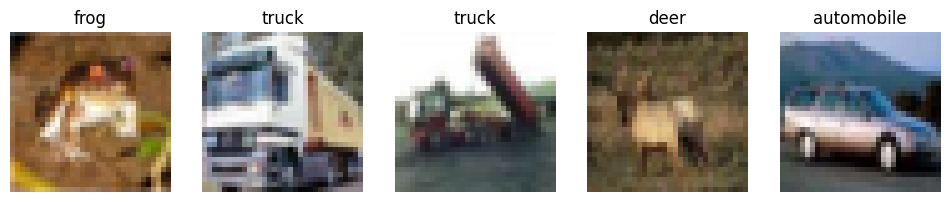

In [ ]:
import matplotlib.pyplot as plt
import torch

def show_images(dataset, n=8):
    plt.figure(figsize=(12,3))
    for i in range(n):
        img, label = dataset[i]

        # unnormalize
        img = img * 0.5 + 0.5

        img = img.permute(1,2,0)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis("off")
    plt.show()

show_images(trainset, 5)


In [ ]:
class CNN(nn.Module):
    def __init__(self, activation):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 10)

        if activation == "relu":
            self.act = nn.ReLU()
        elif activation == "tanh":
            self.act = nn.Tanh()
        elif activation == "leaky":
            self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.act(self.fc1(x)))
        x = self.fc2(x)
        return x


In [ ]:
def init_weights(model, init_type):
    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if init_type == "xavier":
                nn.init.xavier_uniform_(m.weight)
            elif init_type == "kaiming":
                nn.init.kaiming_uniform_(m.weight)
            elif init_type == "random":
                nn.init.uniform_(m.weight)


In [ ]:
def train_model(model, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")


In [ ]:
def evaluate(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


In [ ]:
activations = ["relu", "tanh", "leaky"]
inits = ["random", "xavier", "kaiming"]
optimizers = ["sgd", "adam", "rms"]

best_acc = 0

for act in activations:
    for init in inits:
        for opt in optimizers:
            print(f"\nActivation={act}, Init={init}, Optimizer={opt}")

            model = CNN(act).to(device)
            init_weights(model, init)

            criterion = nn.CrossEntropyLoss()

            if opt == "sgd":
                optimizer = optim.SGD(model.parameters(), lr=0.01)
            elif opt == "adam":
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            elif opt == "rms":
                optimizer = optim.RMSprop(model.parameters(), lr=0.001)

            train_model(model, optimizer, criterion, epochs=5)
            acc = evaluate(model)
            print("Accuracy:", acc)

            if acc > best_acc:
                best_acc = acc
                torch.save(model.state_dict(), "best_cnn.pth")



Activation=relu, Init=random, Optimizer=sgd
Epoch 1, Loss: 4412.1677
Epoch 2, Loss: 2.3028
Epoch 3, Loss: 2.3027
Epoch 4, Loss: 2.3027
Epoch 5, Loss: 2.3026
Accuracy: 10.0

Activation=relu, Init=random, Optimizer=adam
Epoch 1, Loss: 670444.0507
Epoch 2, Loss: 3752.4815
Epoch 3, Loss: 139.8450
Epoch 4, Loss: 50.1350
Epoch 5, Loss: 23.8899
Accuracy: 11.7

Activation=relu, Init=random, Optimizer=rms
Epoch 1, Loss: 349986.7266
Epoch 2, Loss: 42.7676
Epoch 3, Loss: 2.5966
Epoch 4, Loss: 2.3023
Epoch 5, Loss: 2.2631
Accuracy: 16.71

Activation=relu, Init=xavier, Optimizer=sgd
Epoch 1, Loss: 1.9230
Epoch 2, Loss: 1.5888
Epoch 3, Loss: 1.4327
Epoch 4, Loss: 1.3387
Epoch 5, Loss: 1.2687
Accuracy: 55.17

Activation=relu, Init=xavier, Optimizer=adam
Epoch 1, Loss: 1.4209
Epoch 2, Loss: 1.0493
Epoch 3, Loss: 0.8989
Epoch 4, Loss: 0.7985
Epoch 5, Loss: 0.7131
Accuracy: 71.88

Activation=relu, Init=xavier, Optimizer=rms
Epoch 1, Loss: 1.5466
Epoch 2, Loss: 1.1614
Epoch 3, Loss: 1.0055
Epoch 4, Loss

In [ ]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)

train_model(resnet, optimizer, criterion, epochs=5)
resnet_acc = evaluate(resnet)

torch.save(resnet.state_dict(), "resnet18_cifar10.pth")
print("ResNet-18 Accuracy:", resnet_acc)


Epoch 1, Loss: 0.9800
Epoch 2, Loss: 0.5626
Epoch 3, Loss: 0.4046
Epoch 4, Loss: 0.2910
Epoch 5, Loss: 0.2080
ResNet-18 Accuracy: 81.33


In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


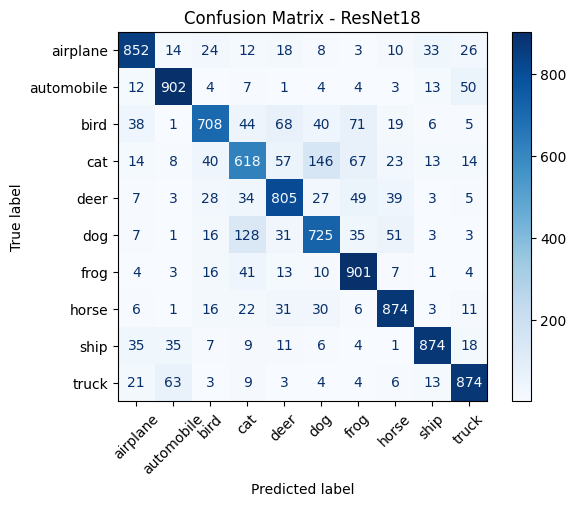

In [ ]:
y_true, y_pred = get_predictions(resnet, testloader)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - ResNet18")
plt.show()


### Confusion Matrix Analysis

The diagonal elements of the confusion matrix represent correct predictions for each class,
while the off-diagonal elements indicate misclassifications.
The model shows strong performance on classes such as airplane and automobile,
while some confusion is observed between visually similar classes like cat and dog.


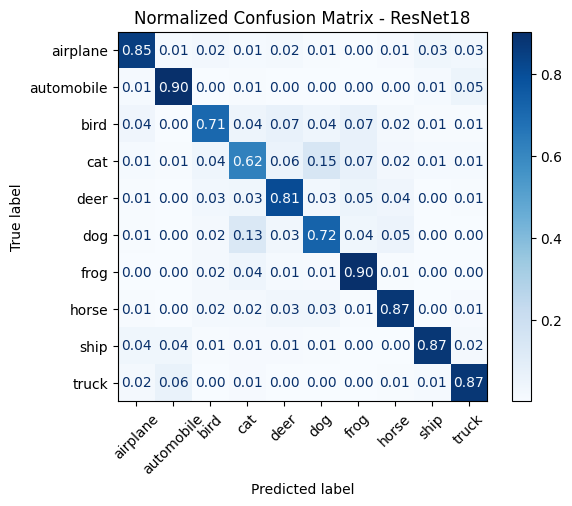

In [ ]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, None]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=classes)
disp.plot(cmap="Blues", xticks_rotation=45, values_format=".2f")
plt.title("Normalized Confusion Matrix - ResNet18")
plt.show()


In [ ]:
acc = evaluate(model)
print("Accuracy:", acc)

Accuracy: 69.21


In [ ]:
print("ResNet-18 Accuracy:", resnet_acc)


ResNet-18 Accuracy: 81.33


In [ ]:
print("Model Comparison")
print("-" * 30)
print(f"Custom CNN Accuracy  : {acc:.2f} %")
print(f"ResNet-18 Accuracy   : {resnet_acc:.2f} %")


Model Comparison
------------------------------
Custom CNN Accuracy  : 69.21 %
ResNet-18 Accuracy   : 81.33 %


### Conclusion
The pretrained ResNet-18 model achieved higher accuracy (81.33%) compared to the custom CNN (69.21%).
This shows that transfer learning significantly improves performance on the CIFAR-10 dataset.
